In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
cm = cmap.inferno

plt.style.use("../thesis-style.mpl")

In [2]:
import numpy as np
import scipy as sp
import theano
import theano.tensor as tt
import theano.tensor.nlinalg
import sys
#sys.path.insert(0, "../../..")
import pymc3 as pm

/home/daniel/.virtualenvs/IGRlaptop21/thesis/lib/python2.7/site-packages/h5py-2.7.0-py2.7-linux-x86_64.egg/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import thesis

In [15]:
x = np.linspace(0, 10, 40) 
x_unc = x + 0.5 * np.random.randn(len(x))
y = np.sin(x*4) + 0.5* np.random.randn(len(x))

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


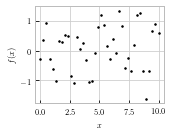

In [82]:
fig = plt.figure(figsize=(figwidth,2)); ax = fig.add_subplot(111)
#ax.plot(X, y, '--', color=cm(0.4))
ax.plot(x, y, '.', ms=3, c='k');
#ax.plot(x, y, ms=3, c='k');
ax.set_xlabel("$x$");
ax.set_ylabel("$f(x)$");
plt.tight_layout()
fig.savefig("../figures/gp-training-data-periodic.pdf")

In [89]:
with pm.Model() as model:
    
    amp = pm.Uniform("amplitude", 1, 100)
    ls = pm.Gamma("metric", alpha=3, beta=0.5)
    period = pm.Gamma("period", alpha=1, beta=0.5)
    
    # Specify the covariance function.
    cov_func = amp*pm.gp.cov.Periodic(1, period=period, ls=ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", .5, 2)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

In [90]:
with model:
    mp = pm.find_MAP()

logp = -41.104, ||grad|| = 0.1273: 100%|██████████| 48/48 [00:00<00:00, 234.72it/s]  


In [91]:
x_new = np.linspace(0,10, 200)[::,None]
mu, var = gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


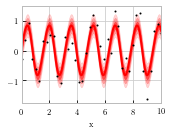

In [107]:
# draw plot
fig = plt.figure(figsize=(figwidth,2)); ax = fig.add_subplot(111)

# plot mean and 2σ intervals
plt.plot(x_new, mu, 'r', lw=2, label="mean and 2σ region");
for deviation in range(1,4):
    plt.fill_between(x_new.flatten(), mu - deviation*sd, mu + deviation*sd, color="r", alpha=0.5/deviation)

# plot original data and true function
plt.plot(x, y, 'ok', ms=1, alpha=1.0, label="observed data");
#plt.plot(x, np.sin(4*x), thesis_colors['blue'], lw=1, label="true f");

plt.xlim([0,10])

plt.xlabel("x");# plt.ylim([-13,13]);
plt.tight_layout()


In [97]:
#asc = float(mp['amplitude'])
ls = float(mp['metric'])
amp = float(mp['amplitude'])
period = float(mp['period'])
#ls= 0.25

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


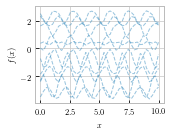

In [102]:
cov_func = amp * pm.gp.cov.Periodic(1, period=period, ls=ls)  
X = x[::,None]#np.linspace(0, 10, 200)[:,None]
K = cov_func(X).eval()
    
fig = plt.figure(figsize=(1*figwidth,1*2))
ax = fig.add_subplot(111)
ax.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T, 
             alpha = 0.5, c=thesis_colors['blue'], lw=1, linestyle="--"
            );
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
fig.tight_layout();
fig.savefig("../figures/gp-example-prior-draws-periodic.pdf")

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


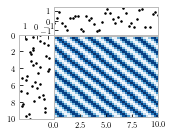

In [103]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2,2, width_ratios=[1,3],
                       height_ratios=[1,3])

fig = plt.figure(figsize=(1*figwidth,1*2))
ax = plt.subplot(gs[1:, 0], )
ax.plot(y,x, '.', ms=3, c='k');

ax.set_ylim([10,0])
ax.set_xlim([1.5, -1.5])
ax.grid(False)
ax.xaxis.tick_top()
ax.set_xticks([-1, 0, 1])
#fig, ax = plt.subplots(2,2, )#, sharex=True, sharey=True);
K = cov_func(x[::,None]).eval()
ax = plt.subplot(gs[1:, 1:])
m = ax.imshow(K, cmap="Blues", interpolation='none', extent = [x.min(), x.max(), x.min(), x.max()], aspect=.78)
ax.set_yticks([])

ax.grid(False)
ax = plt.subplot(gs[0, 1:], )
ax.set_xticks([])
ax.plot(x,y, '.', ms=3, c='k');
ax.set_xlim([0,10])
ax.set_yticks([-1, 0, 1])
ax.set_ylim([-1.5, 1.5])
ax.grid(False)
gs.update(hspace=0., wspace=0.)
fig.savefig("../figures/gp-example-periodic-matrix.pdf")

plt.tight_layout()

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


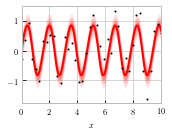

In [108]:
x_new = np.linspace(0,10, 200)[::,None]
mu, var = gp.predict(x_new,  point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(1*figwidth,2)); ax = fig.add_subplot(111)

# plot mean and 2σ intervals
plt.plot(x_new, mu, 'r', lw=2, label="mean and 2σ region");
for deviation in range(1,4):
    plt.fill_between(x_new.flatten(), mu - deviation*sd, mu + deviation*sd, color="r", alpha=0.3/deviation)

# plot original data and true function
plt.plot(x, y, 'ok', ms=1, alpha=1.0, label="observed data");
#plt.plot(x, np.sin(x), "dodgerblue", lw=1, label="true f");

plt.xlabel("$x$");
plt.tight_layout()

#K = cov_func(x_new).eval()
#ax.plot(x_new, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T, 
#             alpha = 0.5, c=thesis_colors['red'], lw=1, linestyle="--",
#            );
ax.set_xlim([0,10])
plt.xlabel("$x$");# plt.ylim([-13,13]);
plt.tight_layout()
plt.savefig("../figures/gp-posterior-periodic-meancovar.pdf")

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


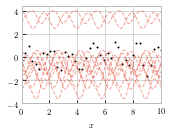

In [109]:
# draw plot
fig = plt.figure(figsize=(1*figwidth,2)); ax = fig.add_subplot(111)

# plot original data and true function
plt.plot(x, y, 'ok', ms=1, alpha=1.0, label="observed data");
#plt.plot(x, np.sin(x), "dodgerblue", lw=1, label="true f");

plt.xlabel("$x$");
plt.tight_layout()

K = cov_func(x_new).eval()
ax.plot(x_new, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T, 
             alpha = 0.5, c=thesis_colors['red'], lw=1, linestyle="--",
            );
ax.set_xlim([0,10])
plt.xlabel("$x$");# plt.ylim([-13,13]);
plt.tight_layout()
plt.savefig("../figures/gp-example-periodic-posterior-draws.pdf")

In [9]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
source_code_pro = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ticks_font = font_manager.FontProperties(**source_code_pro)

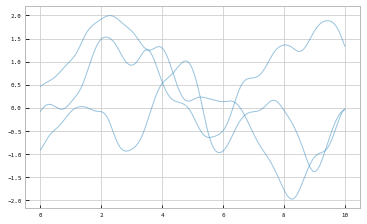

In [11]:
fig, ax = plt.subplots(1,1, figsize=thesis.figsize);
cov_func = pm.gp.cov.RatQuad(1, ls=1, alpha=0.5)
X = np.linspace(0, 10, 200)[:,None]
K = cov_func(X).eval()
ax.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T, 
             alpha = 0.5, c=thesis.colors['blue'], lw=1
            );
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font)

for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


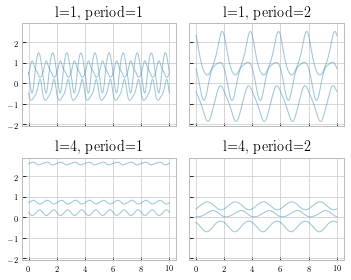

In [115]:
asc = 1
ls = 1


fig, ax = plt.subplots(2,2, figsize=(2*figwidth,2*2), sharex=True, sharey=True);
for i,period in enumerate([1, 2]):
    for j, ls in enumerate([1, 4]):
        cov_func = pm.gp.cov.Periodic(1, ls=ls, period=period)
        X = np.linspace(0, 10, 200)[:,None]
        K = cov_func(X).eval()
        ax[j,i].plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T, 
                     alpha = 0.5, c=thesis_colors['blue'], lw=1
                    );
        ax[j,i].set_title("l={}, period={}".format(ls, period))
fig.tight_layout()
#ax.set_xlabel("X");

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


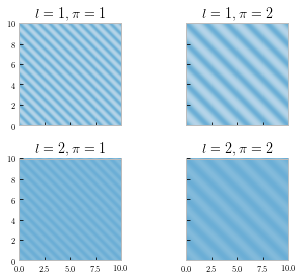

In [119]:
asc = 1
ls = 1


fig, ax = plt.subplots(2,2, figsize=(2*figwidth,2*2), sharex=True, sharey=True);
for i,period in enumerate([1, 2]):
    for j, ls in enumerate([1, 2]):
        cov_func = cov_func = pm.gp.cov.Periodic(1, ls=ls, period=period)
        X = np.linspace(0, 10, 200)[:,None]
        K = cov_func(X).eval()
        m = ax[j,i].imshow(K, cmap="Blues", interpolation='none', extent = [x.min(), x.max(), x.min(), x.max()], vmin=0, vmax=2); 
        #plt.colorbar(m);
        ax[j,i].grid(False)
        
        ax[j,i].set_title("$l={}, \pi={}$".format(ls, period))
fig.tight_layout();
fig.savefig("../figures/gp-example-covariance-matrices-periodic.pdf")
#ax.set_xlabel("X");

In [50]:
with model:
    mp = pm.find_MAP()

logp = -96.259, ||grad|| = 2.6623: 100%|██████████| 20/20 [00:00<00:00, 140.73it/s]  


/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


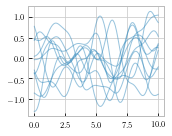

In [58]:
asc = float(mp['amplitude'])
ls = float(mp['metric'])

fig, ax = plt.subplots(1,1, figsize=(figwidth,2), sharex=True, sharey=True);
cov_func = asc * pm.gp.cov.ExpQuad(1, ls)
X = np.linspace(0, 10, 200)[:,None]
K = cov_func(X).eval()
ax.plot(X, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=10).T, 
             alpha = 0.5, c=thesis_colors['blue'], lw=1
            );
#ax[j,i].set_title("l={}, a={}".format(ls, asc))
fig.tight_layout()
#ax.set_xlabel("X");

/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


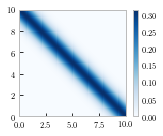

In [74]:
asc = float(mp['amplitude'])
ls = float(mp['metric'])

fig, ax = plt.subplots(1,1, figsize=(figwidth,2), sharex=True, sharey=True);
cov_func = asc * pm.gp.cov.ExpQuad(1, ls)

K = theano.function([], cov_func(x[::,None]))()
m = ax.imshow(K, cmap="Blues", interpolation='none', extent = [x.min(), x.max(), x.min(), x.max()]); plt.colorbar(m);
ax.grid(False)
fig.tight_layout()

In [88]:
with pm.Model() as model:
    
    beta = pm.Gamma("metric", 1,5)
    asc = pm.Gamma("amplitude", 1, 5)
    alpha = pm.Gamma("alpha", 1,4)
    
    # Specify the covariance function.
    cov_func = asc * pm.gp.cov.RatQuad(1, alpha, beta)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 1, 5)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

In [89]:
with model:
    mp = pm.find_MAP()

logp = -99.162, ||grad|| = 0.071873: 100%|██████████| 25/25 [00:00<00:00, 28.67it/s]  


/home/daniel/.virtualenvs/deimos.astro.gla.ac.uk/pymc3/lib/python3.4/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


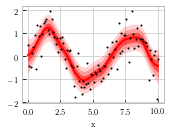

In [90]:
x_new = np.linspace(0,10, 200)[::,None]
mu, var = gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(figwidth,2)); ax = fig.add_subplot(111)

# plot mean and 2σ intervals
plt.plot(x_new, mu, 'r', lw=2, label="mean and 2σ region");
for deviation in range(1,4):
    plt.fill_between(x_new.flatten(), mu - deviation*sd, mu + deviation*sd, color="r", alpha=0.5/deviation)

# plot original data and true function
plt.plot(x, y, 'ok', ms=1, alpha=1.0, label="observed data");
#plt.plot(x, np.sin(x), "dodgerblue", lw=1, label="true f");

plt.xlabel("x");# plt.ylim([-13,13]);
plt.tight_layout()
#plt.title(u"predictive mean and 2σ interval"); plt.legend();